In [27]:
import datetime
from pathlib import Path

import copy
from utils import *
from networks import get_model
from datasets import get_dataloader, reverse_normalize_transform, cifar10_class_names
from attacks.default import auto_attack, pgd_attack
from tqdm import tqdm 

from types import SimpleNamespace

from IPython.display import clear_output
from torchvision import transforms
import matplotlib.pyplot as plt

def show_images(*images, dataset='cifar10'):
    # If only one image is passed, handle it individually
    revtrans = reverse_normalize_transform(dataset)
    
    if len(images) == 1:
        image = revtrans(images[0])
        plt.imshow(transforms.ToPILImage()(image.cpu().detach().squeeze()))
    else:
        fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
        if len(images) == 1:
            axes = [axes]
        for i, image in enumerate(images):
            image = revtrans(image)
            axes[i].imshow(transforms.ToPILImage()(image.cpu().detach().squeeze()))
            axes[i].axis('off')  # Hide the axis for a cleaner display
        
    plt.show()

def set_arguments():
    args = SimpleNamespace()
    
    # base
    args.seed = 0
    args.device = 0
    
    # main decisions
    args.model = 'resnetcifarapt'  # Default value
    args.dataset = 'cifar10'  # Default value
    args.train_env = 'AST'  # Default value
    
    # test time settings
    args.test_time = 'none'  # Default value
    args.test_domain = 'corrupt'  # Default value
    args.corrupt_level = 5  # Default value
    args.corrupt_type = 'gaussian_noise'  # Default value
    args.test_time_iter = 1  # Default value
    
    # detail train/attack decisions
    args.batch_size = 128  # Default value
    args.eps = None  # Default value
    args.attack_iters = 50  # Default value
    args.eval_interval = 1  # Default value
    
    # detail model decisions (iptnet)
    args.patch_size = 1  # Default value
    args.vocab_size = 128  # Default value
    
    # train record path or notes 
    args.ckpt = 'ckpt'  # Default value
    args.record_path = None  # Default value
    
    # post-parsing adjustments
    args.device = f"cuda:{args.device}" if args.device >= 0 and torch.cuda.is_available() else "cpu"
    args.ckpt = Path(args.ckpt)
    args.ckpt.mkdir(exist_ok=True)
    
    if args.record_path is None:
        mmdd = datetime.datetime.now().strftime("%m%d")
        record_path = f'{args.train_env}-{args.model}-{args.dataset}-{mmdd}'
        count = len(list(args.ckpt.glob(f"{record_path}*")))
        suffix = f'_{count+1}' if count >= 1 else ''
        args.record_path = args.ckpt / (record_path + suffix)
    else:
        args.record_path = args.ckpt / args.record_path

    # Adjust epsilon if not provided
    if args.eps is None:
        args.eps = 0.3 if args.dataset == 'mnist' else 8/255

    # Set other attributes based on model/dataset
    args.channels = 3
    args.image_size = 32 if args.dataset != 'imagenet' else 256
    args.num_classes = 10 if args.dataset not in ['imagenet', 'cifar100'] else (100 if args.dataset == 'cifar100' else 1000)

    return args



=== running experiment: AST resnetcifarapt cifar10 ===
>>> model param count: 374586 ≈ 1MB
>>>> ipt config: vocab_size = 128, patch_size=1
Files already downloaded and verified
Files already downloaded and verified
>>>> Dataset: Clean cifar10, no test time augmentation
label is  Cat


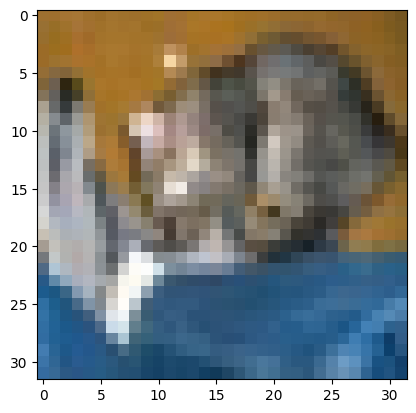

adv/sim training: 100%|███████████████████████████████| 391/391 [01:39<00:00,  3.92it/s]


In [29]:
args = set_arguments()
print()
print(f'=== running experiment: {args.train_env} {args.model} {args.dataset} ===')

# Initialize components based on config
model = get_model(args)
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
Num, whatB = params_to_memory(num_parameters)
param_msg = f'model param count: {num_parameters} ≈ {Num}{whatB}'
print(f'>>> {param_msg}')
# additional information for iptnet
if 'ipt' in args.model or 'apt' in args.model:
    print(f'>>>> ipt config: vocab_size = {args.vocab_size}, patch_size={args.patch_size}')

train_loader, test_loader = get_dataloader(args, test_len=1)

orig_image, label = next(iter(test_loader))
# print('label is ', cifar10_class_names[label.item()])
# show_images(orig_image)


model.train()
model.to(args.device)
optimizer = torch.optim.Adam(model.iptnet.parameters(), lr=1e-3)
opt_class = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)
        
for epoch in range(1, 2):

    # reconstruction pretrain
    pbar = tqdm(train_loader, ncols=90, desc='ast:pretrain')
    for images, labels in pbar:
        images, labels = images.to(args.device), labels.to(args.device)
        adv_images = pgd_attack(args, images, model.iptnet, images, True, attack_iters=7)
        output = model.iptnet(adv_images)
        mseloss = torch.nn.MSELoss()(output, images)
        optimizer.zero_grad()
        mseloss.backward()
        optimizer.step()
        pbar.set_postfix(loss=mseloss.item())

    # adversarial similarity training
    pbar = tqdm(train_loader, ncols=88, desc='adv/sim training')

    for images, labels in pbar:
        images, labels = images.to(args.device), labels.to(args.device)
        adv_images = pgd_attack(args, images, model, labels, False, attack_iters=7)
        output = model.iptnet(adv_images)

        mseloss = torch.nn.MSELoss()(output, images)
        optimizer.zero_grad()
        mseloss.backward()
        optimizer.step()

        cl_output = model.classifier(output.detach())
        loss = torch.nn.CrossEntropyLoss()(cl_output, labels)
        opt_class.zero_grad()
        loss.backward()
        opt_class.step()

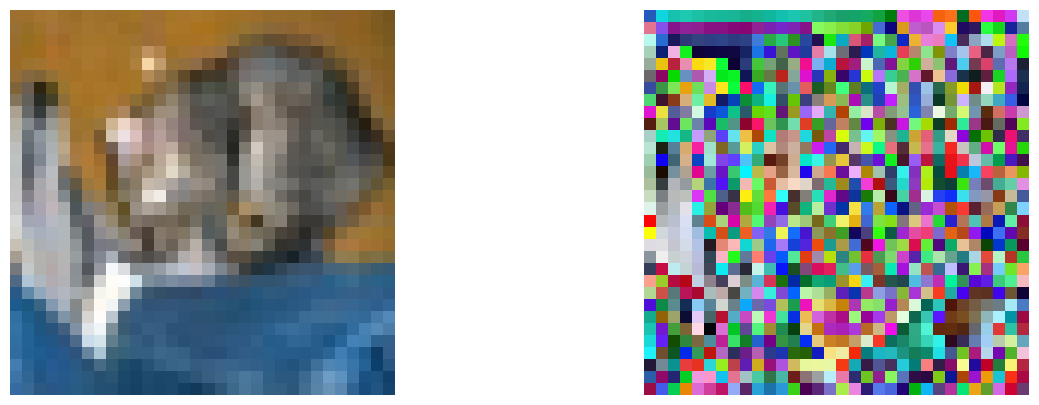

tensor(2.7831, device='cuda:0') tensor(-2.0943, device='cuda:0')


In [30]:
model.eval()
test_correct =  adv_correct = total = 0
for images, labels in test_loader:
    images = images.to(args.device); labels = labels.to(args.device)
    pred = model(images)
    oimage = copy.deepcopy(images)
    # test_correct += float((pred.argmax(dim=1) == labels).sum())
    # adv_images = pgd_attack(args, images, model, labels)
    # adv_images = auto_attack(args, images, model, labels)
    # x = copy.deepcopy(adv_images)
    adv_pred, recon = model(images, True)
    # adv_pred, recon = model(x, True)
    adv_correct += float((adv_pred.argmax(dim=1) == labels).sum())
    total += len(labels)
diff = adv_images - oimage
show_images(oimage, recon)
# show_images(oimage, adv_images, diff, recon)
print(diff.max(), diff.min())